# Using TensorFlow to make some ANNs

In [ ]:
%pip install keras-tuner
%pip install tensorboard-plugin-profile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 22.3 MB/s eta 0:00:00


# Imports

In [ ]:
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path

# Classification

Making neural network to classify types of clothing based on training from [fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist)

## Load Fashion MNIST dataset

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(train_images_full, train_labels_full), (test_images_full, test_labels_full) = fashion_mnist

# Remove last 5000 images for validation
train_images = train_images_full[:-5000]
train_labels = train_labels_full[:-5000]

validation_images = train_images_full[-5000:]
validation_labels = train_labels_full[-5000:]

# Look at data
print(train_images.shape)

# Scale pixels to (0-1)
train_images = train_images / 255.0
validation_images = validation_images / 255.0
test_images_full = test_images_full / 255.0

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(55000, 28, 28)


## Create Model

In [ ]:
# Uses sequential API and keras-tuner

def build_fashion_model(hp):
  n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
  n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
  learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
  optimizer = hp.Choice("optimizer", values=["sgd", "adam"])

  if optimizer == "sgd":
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  else:
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))

  for _ in range(n_hidden):
    model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))

  model.add(tf.keras.layers.Dense(10, activation="softmax"))

  model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

  return model

In [ ]:
class FashionClassificationHypterModel(kt.HyperModel):
  def build(self, hp):
    return build_fashion_model(hp)

  def fit(self, hp, model, X, y, **kwargs):
    if hp.Boolean("normalize"):
      norm_layer = tf.keras.layers.Normalization()
      X = norm_layer(X)
    return model.fit(X, y, **kwargs)

## Train Model with Hyperparameter Tuning

### Do Hyperparameter Tuning

In [ ]:
# Hyperband allocates resources better than pure random search
fashion_hyperband_tuner = kt.Hyperband(
    FashionClassificationHypterModel(),
    objective="val_accuracy",
    max_epochs=10,
    factor=3,
    directory="fashion_mnist_hyperband",
    project_name="hyperband_tuning")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
fashion_root_logdir = Path(fashion_hyperband_tuner.project_dir) / "tensorboard"
fashion_tensorboard_cb = tf.keras.callbacks.TensorBoard(fashion_root_logdir) # Allows for TensorBoard visualization
fashion_early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2) # Interrupts training when no progress on validation set for 2 trials
fashion_hyperband_tuner.search(train_images, train_labels, epochs=10,
validation_data=(validation_images, validation_labels),
callbacks=[fashion_early_stopping_cb, fashion_tensorboard_cb])

Trial 30 Complete [00h 01m 31s]
val_accuracy: 0.8561999797821045

Best val_accuracy So Far: 0.8895999789237976
Total elapsed time: 00h 17m 17s


### Get best model

In [ ]:
top_3_fashion_models = fashion_hyperband_tuner.get_best_models(num_models=3)
best_fashion_model = top_3_fashion_models[0]

best_fashion_trial = fashion_hyperband_tuner.oracle.get_best_trials(num_trials=1)[0]
best_fashion_trial.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Trial 0016 summary
Hyperparameters:
n_hidden: 4
n_neurons: 254
learning_rate: 0.00024654929327663945
optimizer: adam
normalize: True
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.8895999789237976


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Evalute model

In [ ]:
best_fashion_model.evaluate(test_images_full, test_labels_full)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8876 - loss: 0.3452


[0.3457441031932831, 0.8842999935150146]

## Save model

In [ ]:
best_fashion_model.save("tf_fashion_mnist_ann.keras")

# Regression

Using neural net to make predictions based on Auto MPG dataset

## Get Data

In [ ]:
mpg_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
mpg_column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(mpg_url, names=mpg_column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

mpg_dataset = raw_dataset.copy()
mpg_dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Clean data

In [ ]:
mpg_dataset = mpg_dataset.dropna() # Remove entries w/ unknown values

mpg_dataset['Origin'] = mpg_dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'}) # One-hot encode to numerical
mpg_dataset = pd.get_dummies(mpg_dataset, prefix='', prefix_sep='')
mpg_dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
393,27.0,4,140.0,86.0,2790.0,15.6,82
394,44.0,4,97.0,52.0,2130.0,24.6,82
395,32.0,4,135.0,84.0,2295.0,11.6,82
396,28.0,4,120.0,79.0,2625.0,18.6,82
397,31.0,4,119.0,82.0,2720.0,19.4,82


## Make training and test sets

In [ ]:
mpg_train_set = mpg_dataset.sample(frac=0.8, random_state=0)
mpg_test_set = mpg_dataset.drop(mpg_train_set.index)

### Inspect data

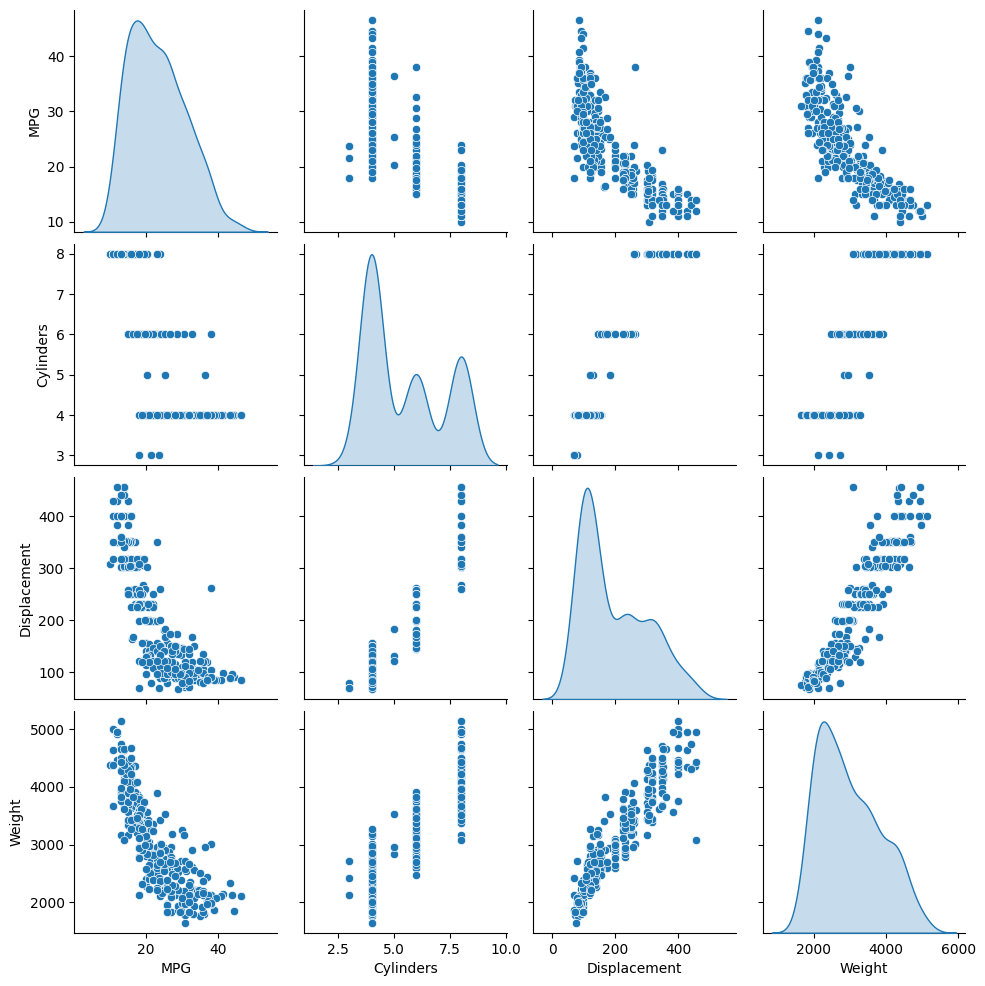

In [ ]:
# Plot variables

sns.pairplot(mpg_train_set[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [ ]:
# See overall statistics

mpg_train_set.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


### Remove label from features

In [ ]:
mpg_train_features = mpg_train_set.copy()
mpg_test_features = mpg_test_set.copy()

mpg_train_labels = mpg_train_features.pop('MPG')
mpg_test_labels = mpg_test_features.pop('MPG')


### Normalize Features

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(mpg_train_features))

## Create Model

In [ ]:
auto_mpg_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1) # B/c regression outputs 1 value
])

## Specify loss function and optimizer to use

In [ ]:
auto_mpg_model.compile(loss='mse',
                       optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                       metrics=["RootMeanSquaredError"])


## Train Model

In [ ]:
auto_mpg_history = auto_mpg_model.fit(
    mpg_train_features, mpg_train_labels,
    epochs=200, validation_split=0.2
)

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - RootMeanSquaredError: 2.5645 - loss: 6.6031 - val_RootMeanSquaredError: 3.0064 - val_loss: 9.0385
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - RootMeanSquaredError: 2.6431 - loss: 6.9992 - val_RootMeanSquaredError: 3.0097 - val_loss: 9.0586
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - RootMeanSquaredError: 2.6526 - loss: 7.0491 - val_RootMeanSquaredError: 2.9994 - val_loss: 8.9967
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - RootMeanSquaredError: 2.5200 - loss: 6.3698 - val_RootMeanSquaredError: 3.0044 - val_loss: 9.0265
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - RootMeanSquaredError: 2.5085 - loss: 6.3336 - val_RootMeanSquaredError: 2.9909 - val_loss: 8.9457
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - RootMeanSquaredError: 2.4830 - loss: 6.1766 - val_RootMeanSquaredError: 2.9871 - val_loss: 8.9230
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - RootMeanSquaredError: 2.3149 - loss: 5.4069 - va

## Visualize Performance

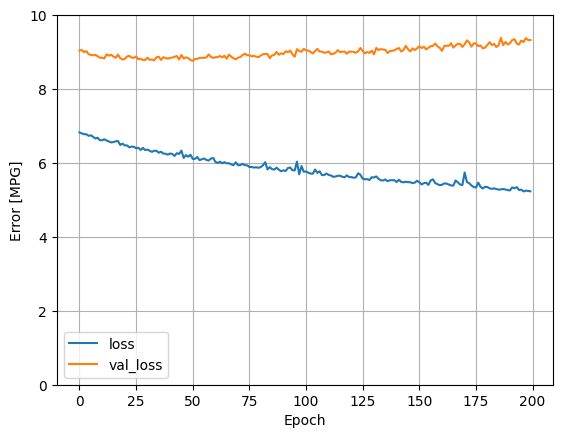

In [ ]:
plt.plot(auto_mpg_history.history['loss'], label='loss')
plt.plot(auto_mpg_history.history['val_loss'], label='val_loss')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)
plt.show()

## Evaluate Model

In [ ]:
mpg_test_results = {}

mpg_test_results['auto_mpg_model'] = auto_mpg_model.evaluate(
    mpg_test_features, mpg_test_labels, verbose=0)

print(mpg_test_results)

{'auto_mpg_model': [6.388852596282959, 2.527617931365967]}


## Save Model

In [ ]:
auto_mpg_model.save("tf_auto_mpg_ann.keras")